# Use PyPSA for a microgrid

This example aims at proposing a sample optimization using PyPSA.

This file proposes the optimal sizing of a PV-Wind-Diesel microgrid in Soroti, Uganda, (1.7250° N, 33.6208° E).
The schematic of the microgrid is the following:

<center><img src="./imgs/microgrid.png" alt="drawing" width="400"/></center>


The procedure leverages on:
- the case study presented in [D. Fioriti et. al, 2022, Multiple design options for sizing off-grid microgrids: A novel single-objective approach to support multi-criteria decision making, Sustainable Energy, Grids and Networks](https://doi.org/10.1016/j.segan.2022.100644),
- complemented with the wind parameters highligted in [D. Fioriti et al, Coupling economic multi-objective optimization and multiple design options: A business-oriented approach to size an off-grid hybrid microgrid, 2021, IJEPES](https://doi.org/10.1016/j.ijepes.2020.106686)

In particular, the following data sources are used:
- **Demand**: the demand inputs are obtained from the paper (D. Fioriti et. al, 2022) referenced above
- **PV and Wind**: the solar photovoltaic (PV) and wind time series are obtained using the [Renewable.ninja platform](https://renewables.ninja/), heavily backed by strong scientific background (see [documentation](https://renewables.ninja/documentation/)); the cost parameters are those of the paper (D. Fioriti et. al, 2021)
- **Other cost assumptions**: based on the paper (D. Fioriti et. al, 2021)

## Package imports

Section to first import the major packages used in the notebook.
Note: the PyPSA-Earth environment is suitable to run this notebook.

In [1]:
# package to handle efficient numeric structures (vectors/matrices) mathematical operations
import numpy as np
# package to handle databases, e.g. tabular data
import pandas as pd
# energy modelling package
import pypsa
# package to make plots
import matplotlib.pyplot as plt

Some global constants used for simplifying the code

In [2]:
# figure size
FIGSIZE = (5, 2.5)
# solver of the optimization
SOLVER = "glpk"

## 1. Data import

### PV

The available PV production for every hour of 2019 is estimated using Renewables.ninja platform, using standard inputs for the PV plant (tilt angle, orientation, etc.).
The data are downloaded manually and loaded into the data folder with name `ninja_pv_1.7250_33.6208_uncorrected.csv`.

In the following, the file is loaded also including some plottings for easy visualization.

In [3]:
# file name of the pv data
pv_file = 'data/ninja_pv_1.7250_33.6208_uncorrected.csv'

# Load the CSV file
df_pv = pd.read_csv(pv_file, skiprows=3)  # skip the first 3 rows
df_pv.rename(columns={'electricity': 'pv'}, inplace=True)  # rename the electricity column

df_pv.head(5)  # show the first 5 rows

,time,local_time,pv
0,2019-01-01 00:00,2019-01-01 03:00,0.000
1,2019-01-01 01:00,2019-01-01 04:00,0.000
2,2019-01-01 02:00,2019-01-01 05:00,0.000
3,2019-01-01 03:00,2019-01-01 06:00,0.000
4,2019-01-01 04:00,2019-01-01 07:00,0.213


<Axes: xlabel='Hour of the year', ylabel='PV av. prod [kW/kWp]'>

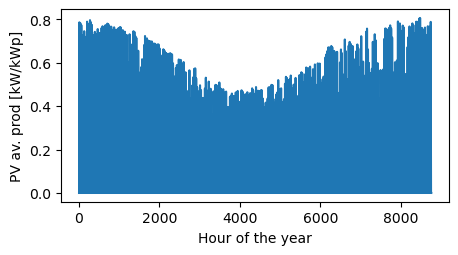

In [4]:
# plot the pv data
df_pv["pv"].plot(xlabel="Hour of the year", ylabel="PV av. prod [kW/kWp]", figsize=FIGSIZE)

### Wind

The available wind production for every hour of 2019 is estimated using Renewables.ninja platform, using standard inputs for the PV plant (tilt angle, orientation, etc.).
The data are downloaded manually and loaded into the data folder with name `ninja_wind_1.7250_33.6208_uncorrected.csv`.

In the following, the file is loaded also including some plottings for easy visualization.

In [5]:
# file name of the pv data
wind_file = 'data/ninja_wind_1.7250_33.6208_uncorrected.csv'

# Load the CSV file
df_wind = pd.read_csv(wind_file, skiprows=3)  # skip the first 3 rows
df_wind.rename(columns={'electricity': 'wind'}, inplace=True)  # rename the electricity column

df_wind.head(5)  # show the first 5 rows

,time,local_time,wind
0,2019-01-01 00:00,2019-01-01 03:00,0.360
1,2019-01-01 01:00,2019-01-01 04:00,0.355
2,2019-01-01 02:00,2019-01-01 05:00,0.339
3,2019-01-01 03:00,2019-01-01 06:00,0.312
4,2019-01-01 04:00,2019-01-01 07:00,0.194


<Axes: xlabel='Hour of the year', ylabel='Wind av. prod [kW/kWp]'>

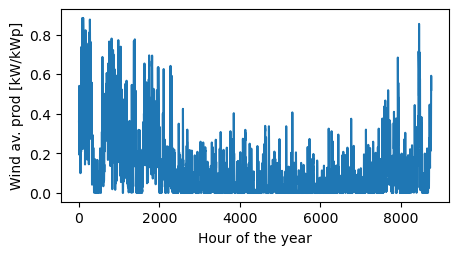

In [6]:
# plot the pv data
df_wind["wind"].plot(xlabel="Hour of the year", ylabel="Wind av. prod [kW/kWp]", figsize=FIGSIZE)

### Load

The load demand is obtained from the paper by D.Fioriti et al.

In the activity, a so-called 'typical daily' profile was estimated using the tool LoadProGen, now available as [RAMP](https://rampdemand.org/).

In the data folder, the file `demand_data.csv` contains the following two columns:
1. the first column is the average demand for every hour of the day
2. the second column is the standard deviation of the demand for every hour of the day

Text(0, 0.5, 'Demand [kW]')

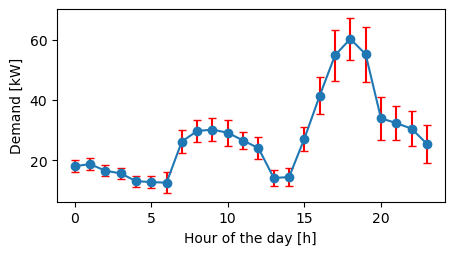

In [7]:
# file name of the pv data
demand_file = 'data/demand_data.csv'

# Load the CSV file
df_demand_day = pd.read_csv(demand_file)
df_demand_day["hour"] = range(0, 24)

confidence_factor = 1.96  # 95% confidence interval

plt.figure(figsize=FIGSIZE)
plt.errorbar(
    x=df_demand_day["hour"],
    y=df_demand_day["demand"],
    yerr=confidence_factor * df_demand_day["standard_deviation"],
    fmt='-o',
    ecolor='r',
    capsize=3,
)
plt.xlabel("Hour of the day [h]")
plt.ylabel("Demand [kW]")

Note that in typical offgrid systems, in first approximation, the demand is assumed to be invariant over the year.

Therefore, in the following, we generate a yearly time series of demand by randomly sampling the demand for every hour of the day from a normal distribution with mean and standard deviation as above.

In [8]:
n_days = 365  # number of days to simulate

df_demand_year = np.random.normal(
    np.tile(df_demand_day["demand"], n_days),
    np.tile(df_demand_day["standard_deviation"], n_days),
)

df_demand = pd.DataFrame(
    df_demand_year,
    columns=["demand"],
    index=df_pv.index,
)
df_demand.shape

(8760, 1)

In the following, we show a plot of the entire dataset to show the variability of the time series.

Text(0, 0.5, 'Demand [kW]')

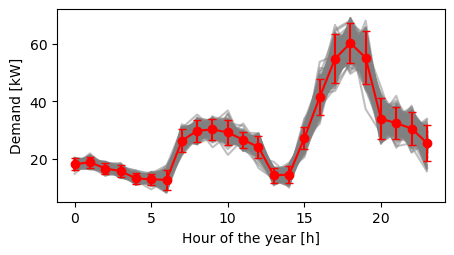

In [9]:
plt.figure(figsize=FIGSIZE)
plt.plot(
    df_demand_day["hour"],
    np.reshape(df_demand["demand"].values, (-1, 24)).T,
    color='gray',
    alpha=0.5,
    label="Demand",
)
plt.errorbar(
    x=df_demand_day["hour"],
    y=df_demand_day["demand"],
    yerr=confidence_factor * df_demand_day["standard_deviation"],
    fmt='-o',
    color='r',
    capsize=3,
)
plt.xlabel("Hour of the year [h]")
plt.ylabel("Demand [kW]")

The yearly plot is then the following

Text(0, 0.5, 'Demand [kW]')

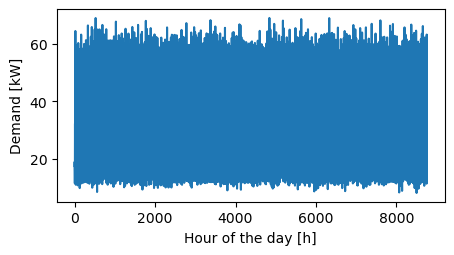

In [10]:
# plot the demand
plt.figure(figsize=FIGSIZE)
plt.plot(df_demand["demand"])
plt.xlabel("Hour of the day [h]")
plt.ylabel("Demand [kW]")

To ehnance the analysis, also a heatmap is added to show the demand for every hour of the day.

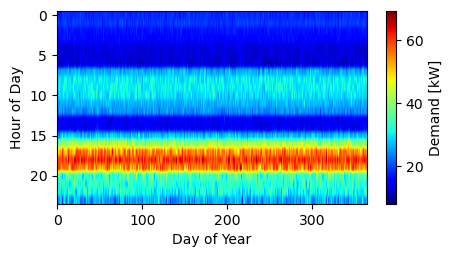

In [11]:
# Reshape the demand data into a 2D array
demand_matrix = df_demand.values.reshape(-1, 24)

plt.figure(figsize=FIGSIZE)
# Create the heatmap plot
plt.imshow(demand_matrix.T, cmap='jet', aspect='auto')

# Set the x-axis and y-axis labels
plt.xlabel('Day of Year')
plt.ylabel('Hour of Day')

# Set the colorbar
plt.colorbar(label='Demand [kW]')

# Show the plot
plt.show()


For simplicity, all time series data are now aggregated into a single dataframe for simplicity

In [12]:
# merge the data into one dataframe
df_data = pd.concat(
    [df_pv[["pv"]], df_wind[["wind"]], df_demand],
    axis=1,
)

# add a datetime index (optional)
# df_data.index = df_pv.time

df_data.head(5)

,pv,wind,demand
0,0.000,0.360,17.386393
1,0.000,0.355,18.867393
2,0.000,0.339,16.316692
3,0.000,0.312,15.551771
4,0.213,0.194,11.980693


## 2. Create input cost parameters

This section aims at describing the cost parameters used in the optimization.

To do so, the goal is to create a dataframe of major input parameters, for each technology, including:
- **CAPEX**: capital expenditure
- **OPEX**: operational expenditure, divided into two independent components:
    - ***Fixed* OPEX**: expenditure *independent* from the energy production
    - ***Marginal* OPEX**: expenditure *dependent* from the energy production
- **Lifetime**: lifetime of the technology
- **Efficiency**: efficiency of the technology
- **Discount rate**: discount rate of the analysis

In [13]:
# Initialize the dataframe: columns indicate cost components and rows indicate technologies
assumptions = pd.DataFrame(
    columns=["CAPEX", "discount rate", "efficiency", "OPEX_fixed", "OPEX_marginal", "lifetime"],
    index=["default", "pv", "wind", "battery", "diesel"],
)

# default parameters
assumptions.at["default", "OPEX_fixed"] = 3.0
assumptions.at["default", "OPEX_marginal"] = 0.0
assumptions.at["default", "discount rate"] = 0.08
assumptions.at["default", "lifetime"] = 20

# pv technology
assumptions.at["pv", "CAPEX"] = 900  # EUR/kWp
assumptions.at["pv", "OPEX_fixed"] = 16  # EUR/kWp/year
assumptions.at["pv", "lifetime"] = 25  # years

# wind technology
assumptions.at["wind", "CAPEX"] = 2400  # EUR/kWp
assumptions.at["wind", "OPEX_fixed"] = 80  # EUR/kWp/year
assumptions.at["wind", "lifetime"] = 20  # years

# battery technology
assumptions.at["battery", "CAPEX"] = 450  # EUR/kWh
assumptions.at["battery", "OPEX_fixed"] = 3  # EUR/kWh/year
assumptions.at["battery", "efficiency"] = 0.9  # [-] per unit
assumptions.at["battery", "lifetime"] = 10  # years

# diesel technology
fuel_price = 1.4  # EUR/l
fuel_energy_density = 10  # kWh/l
efficiency_diesel = 0.33  # [-] per unit

maintenance_diesel = 0.05  # EUR/kW/h

assumptions.at["diesel", "CAPEX"] = 6e2  # EUR/kW
assumptions.at["diesel", "OPEX_marginal"] = \
    (fuel_price / fuel_energy_density * efficiency_diesel + maintenance_diesel)  # EUR/kWh
assumptions.at["diesel", "lifetime"] = 3  # years

# fill defaults
assumptions = assumptions.fillna(
    {
        "OPEX_fixed": assumptions.at["default", "OPEX_fixed"],
        "OPEX_marginal": assumptions.at["default", "OPEX_marginal"],
        "discount rate": assumptions.at["default", "discount rate"],
        "lifetime": assumptions.at["default", "lifetime"],
    }
)

# save to file
assumptions.to_csv("assumptions.csv")

assumptions

C:\Users\Davide\AppData\Local\Temp\ipykernel_35636\149235735.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  assumptions = assumptions.fillna(


,CAPEX,discount rate,efficiency,OPEX_fixed,OPEX_marginal,lifetime
default,NaN,0.08,NaN,3.0,0.0000,20
pv,900,0.08,NaN,16.0,0.0000,25
wind,2400,0.08,NaN,80.0,0.0000,20
battery,450,0.08,0.9,3.0,0.0000,10
diesel,600.0,0.08,NaN,3.0,0.0962,3


The objective of the system is to minimize the annualized costs, which are computed as follows:

$$
\text{Annualized costs} = OPEX + \sum_{i \in A} {CRF}_i * {CAPEX}_i\\
CRF_i = \frac{r(1+d)^{L_i}}{(1+d)^{L_i}-1}
$$

where:
- $A$ is the set of technologies
- $d$ is the discount rate
- $L_i$ is the lifetime of the technology $i$

In [14]:
def annuity(lifetime, rate):
    """
    Calculate the annuity factor for a given lifetime and discount rate.
    """
    if rate == 0.0:
        return 1 / lifetime
    else:
        return rate / (1.0 - 1.0 / (1.0 + rate) ** lifetime)


# calculate annuity for every technology
assumptions["annuity"] = assumptions.apply(
    lambda x: annuity(x["lifetime"], x["discount rate"]), axis=1
)

# annualise investment costs, add fixed OPEX to calculate the parameter `capital_cost` for the PyPSA model
assumptions["capital_cost"] = [
    v["annuity"] * v["CAPEX"] + v["OPEX_fixed"]
    for i, v in assumptions.iterrows()
]

assumptions

,CAPEX,discount rate,efficiency,OPEX_fixed,OPEX_marginal,lifetime,annuity,capital_cost
default,NaN,0.08,NaN,3.0,0.0000,20,0.101852,NaN
pv,900,0.08,NaN,16.0,0.0000,25,0.093679,100.310901
wind,2400,0.08,NaN,80.0,0.0000,20,0.101852,324.445301
battery,450,0.08,0.9,3.0,0.0000,10,0.149029,70.063270
diesel,600.0,0.08,NaN,3.0,0.0962,3,0.388034,235.820108


## 3. PyPSA model

This second block of code is used to define the PyPSA model.

The model is a 1-node energy system that contains the following components:
- **Load**: the load is defined as a fixed **Load** component, with the time series of demand as defined above
- **PV**: the PV is defined as a **Generator**
- **Wind**: the wind is defined as a **Generator**
- **Battery**: the battery is defined as a **Storage Unit**
- **Diesel**: the diesel generator is defined as a **Generator**

All assets (PV, Wind, Battery and Diesel generator) are assumed to be expandable: the optimization will determine the optimal size of each asset.
*Note*: we assume that the costs of components are linearly to their capacity.

### Create the basic PyPSA model

In [15]:
# Create an empty PyPSA network
n = pypsa.Network()

# set the snapshots of the simulation, being the time steps of the data
n.set_snapshots(df_data.index)

# Add a bus for the microgrid
n.add("Bus", "microgrid", carrier="AC")

### Add the load

We now add the load to the model.

In [16]:
n.add("Load", "load", bus="microgrid", p_set=df_data["demand"])

To verify the load component is added, we can print the loads object in the PyPSA model.

The cell shows that a load object is indeed added to the bus microgrid.

In [17]:
n.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
load,microgrid,,,0.0,0.0,-1.0


To verify the time series that has been added, we can check the object `n.loads_t.p_set` that contains the time series of the load.

In [18]:
n.loads_t.p_set

Load,load
snapshot,
0,17.386393
1,18.867393
2,16.316692
3,15.551771
4,11.980693
...,...
8755,46.544350
8756,32.143020
8757,28.236214


### Add renewable technologies

In [19]:
RES_techs = ["pv", "wind"]

n.madd(
    "Generator",  # Each RES technology is represented with a "Generator" component
    RES_techs,
    carrier="AC",
    bus="microgrid",  # connect the generators to the microgrid bus
    p_max_pu=df_data[RES_techs],  # specify a maximum per-unit production for every time-step
    capital_cost=assumptions.loc[RES_techs, "capital_cost"],  # specify the capital cost
    p_nom_extendable=True,  # Specify the installed capacity as an optimisation variable
)
# Note: this is a madd function (multiple-add) which adds multiple components at once

Index(['pv', 'wind'], dtype='object')

To verify the load component is added, we can print the loads object in the PyPSA model.

The cell shows that two generator objects are indeed added to the bus microgrid.

In [20]:
n.generators

,carrier,bus,capital_cost,p_nom_extendable,control,type,p_nom,p_nom_mod,p_nom_min,p_nom_max,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
pv,AC,microgrid,100.310901,True,PQ,,0.0,0.0,0.0,inf,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
wind,AC,microgrid,324.445301,True,PQ,,0.0,0.0,0.0,inf,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


The time series of the PV and Wind are added to the model, in the object `n.generators_t.p_max_pu`.

In [21]:
n.generators_t.p_max_pu

Generator,pv,wind
snapshot,,
0,0.000,0.360
1,0.000,0.355
2,0.000,0.339
3,0.000,0.312
4,0.213,0.194
...,...,...
8755,0.000,0.572
8756,0.000,0.592
8757,0.000,0.590


### Add the battery

In [22]:
n.add(
    "StorageUnit",
    "battery",
    bus="microgrid",
    p_nom_extendable=True,
    capital_cost=assumptions.at["battery", "capital_cost"],
    cyclic_state_of_charge=True,
)

### Add the diesel generator

Now we add a diesel generator, and verify it is added to the `n.generators` object.

In [23]:
n.add(
    "Generator",
    "diesel",
    bus="microgrid",
    carrier="AC",
    p_nom_extendable=True,
    capital_cost=assumptions.at["diesel", "capital_cost"],
    marginal_cost=assumptions.at["diesel", "OPEX_marginal"],
)

n.generators

,carrier,bus,capital_cost,p_nom_extendable,control,type,p_nom,p_nom_mod,p_nom_min,p_nom_max,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
pv,AC,microgrid,100.310901,True,PQ,,0.0,0.0,0.0,inf,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
wind,AC,microgrid,324.445301,True,PQ,,0.0,0.0,0.0,inf,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
diesel,AC,microgrid,235.820108,True,PQ,,0.0,0.0,0.0,inf,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


## 4. Optimization of the model

Now we execute the model with the default GLPK solver.
Note that the solver can be changed to other solvers, such as CPLEX or Gurobi, that are commercial solvers with better performances.

For your possible thesis, in case of need, CPLEX and Gurobi are freely accessible with your academic email.

In [24]:
n.optimize(solver_name=SOLVER)

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 76.13it/s]
INFO:linopy.io: Writing time: 0.55s
INFO:linopy.solvers:GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\Davide\AppData\Local\Temp\linopy-problem-izpbkn38.lp --output
 C:\Users\Davide\AppData\Local\Temp\linopy-solve-sn0ez_r3.sol
Reading problem data from 'C:\Users\Davide\AppData\Local\Temp\linopy-problem-izpbkn38.lp'...
122644 rows, 52564 columns, 231273 non-zeros
660534 lines were read
GLPK Simplex Optimizer 5.0
122644 rows, 52564 columns, 231273 non-zeros
Preprocessing...
64829 rows, 47313 columns, 168207 non-zeros
Scaling...
 A: min|aij| =  1.000e-03  max|aij| =  1.000e+00  ratio =  1.000e+03
GM: min|aij| =  3.333e-01  max|aij| =  3.000e+00  ratio =  9.003e+00
EQ: min|aij| =  1.147e-01  max|aij| =  1.000e+00  ratio =  8.718e+00
Constructing initial basis...
Size of triangular part is

('ok', 'optimal')

## 5. Investigate the results

### 5.1 Objective value

In the following, we investigate the value of the objective function and notable values.

The objective

In [25]:
n.objective

35425.42023

### 5.2 Optimal investment capacities

In the following, we show the optimal investment capacities by components.
To do so, we first merge all the optimal capacities for all components (generators, links, stores, storage_units and lines) and then we show a summary table.

Note: the optimized variable for each component is different:
- `p_nom_opt` is the nominal (power) capacity for `generators`, `links` and `storage_units`
- `e_nom_opt` is the nominal (energy) capacity for `stores`
- `s_nom_opt` is the nominal (apparent power) capacity for `lines`

To clarify the results, in the following we concatenate all the results.
For each component type, we create a column in a dataframe and populate the corresponding values with the optimal capacity.
To ease the visualization, each column name is renamed to highlight the corresponding component.

In [26]:
pd.concat([
    n.generators.p_nom_opt.rename("p_nom_opt - Generator"),
    n.links.p_nom_opt.rename("p_nom_opt - Link"),
    n.storage_units.p_nom_opt.rename("p_nom_opt - Storage Unit"),
    n.stores.e_nom_opt.rename("e_nom_opt - Store"),
    n.lines.s_nom_opt.rename("s_nom_opt - Line"),
], axis=1)

,p_nom_opt - Generator,p_nom_opt - Link,p_nom_opt - Storage Unit,e_nom_opt - Store,s_nom_opt - Line
pv,55.3863,NaN,NaN,NaN,NaN
wind,0.0000,NaN,NaN,NaN,NaN
diesel,41.8005,NaN,NaN,NaN,NaN
battery,NaN,NaN,65.5632,NaN,NaN


### 5.3 Collect major energy statistics

In the following, the goal is to collect major statistics on the total energy produced to supply the load.

Note that the time series of any quantity of the different objects is stored into the object `{object}_t`, where `{object}` is any pypsa component, such as generators, links, etc.

To do this, we first create a dataframe that contains all time series for any object and then we sum the quantities to identify the desired quantities.

In [27]:
all_dispatch = pd.concat(
    [
        n.generators_t.p,
        n.storage_units_t.p,
        n.stores_t.p,
    ],
    axis=1,
)

total_dispatch = all_dispatch.sum()

Let's compare the quantities with respect to the total demand

In [28]:
total_demand = n.loads_t.p_set.values.sum()

total_dispatch/total_demand

pv         3.382207e-01
wind       0.000000e+00
diesel     6.617794e-01
battery    2.312643e-09
dtype: float64

Let's now check the total renewable curtailment by comparing the available renewable production versus the actual production.

In [29]:
# get RES technologies that are actually installed
existing_RES_techs = n.generators.index.intersection(RES_techs)

total_available_RES = n.generators_t.p_max_pu[existing_RES_techs].sum() * n.generators.p_nom_opt[existing_RES_techs]
total_available_RES

Generator
pv      84428.438723
wind        0.000000
dtype: float64

In [30]:
RES_curtailment = total_available_RES - total_dispatch[existing_RES_techs]

RES_curtailment/total_available_RES

Generator
pv      0.029784
wind         NaN
dtype: float64

### 5.4 Plot the energy dispatch

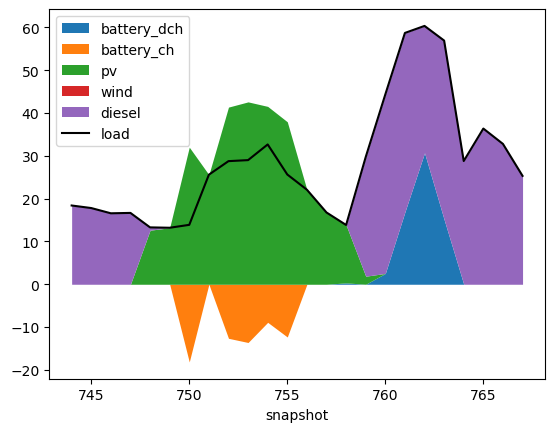

In [31]:
# Day to start the plotting from
init_day_plot = 31
# Number of days to plot
n_days_to_plot = 1

subset_sns = n.generators_t.p.index[init_day_plot*24:(init_day_plot*24 + n_days_to_plot*24)]

# collect discharge power of storages
p_dch_stores = n.storage_units_t.p.loc[subset_sns, :].clip(lower=0.0)  # negative values become 0.0
p_dch_stores.columns = p_dch_stores.columns + "_dch"

# collect charge power of storages
p_ch_stores = n.storage_units_t.p.loc[subset_sns, :].clip(upper=0.0)  # positive values become 0.0
p_ch_stores.columns = p_ch_stores.columns + "_ch"

# create a dataframe to plot the quantities to plot
data_to_plot = pd.concat(
    [
        p_dch_stores,
        p_ch_stores,
        n.generators_t.p.loc[subset_sns, :],
    ],
    axis=1,
)


ax = data_to_plot.plot.area(linewidth=0.0) #, figsize=FIGSIZE)

plt.plot(df_data.loc[subset_sns, "demand"], label="load", color="k")
plt.legend()